In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-4  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.01


In [3]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 144/144 [00:02<00:00, 71.32it/s]


In [4]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [5]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [6]:
!nvidia-smi

Mon Dec  9 12:17:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P5             19W /  290W |    3325MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [8]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 1.113633 val loss: 1.127688
saving, val loss enhanced: 1.1276880125953872 10000
Epoch: 2 	Training Loss: 1.106903 val loss: 1.112277
saving, val loss enhanced: 1.1122767806866423 1.1276880125953872
Epoch: 3 	Training Loss: 1.091941 val loss: 1.094403
saving, val loss enhanced: 1.0944033981634869 1.1122767806866423
Epoch: 4 	Training Loss: 1.086016 val loss: 1.083263
saving, val loss enhanced: 1.0832628865518195 1.0944033981634869
Epoch: 5 	Training Loss: 1.065652 val loss: 1.069282
saving, val loss enhanced: 1.069282482187241 1.0832628865518195
Epoch: 6 	Training Loss: 1.055978 val loss: 1.057822
saving, val loss enhanced: 1.05782174845059 1.069282482187241
Epoch: 7 	Training Loss: 1.045843 val loss: 1.060030
Epoch: 8 	Training Loss: 1.040692 val loss: 1.031788
saving, val loss enhanced: 1.0317878010773132 1.05782174845059
Epoch: 9 	Training Loss: 1.026734 val loss: 1.030685
saving, val loss enhanced: 1.0306846467477686 1.0317878010773132
Epoch: 10 	Training Lo

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4328.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4393.53iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002896 val loss: 0.003072
saving, val loss enhanced: 0.003072188214375338 1000000000000000.0
Epoch: 2 	Training Loss: 0.002896 val loss: 0.003072
saving, val loss enhanced: 0.003071906759523701 0.003072188214375338
Epoch: 3 	Training Loss: 0.002896 val loss: 0.003072
saving, val loss enhanced: 0.0030716253443726256 0.003071906759523701
Epoch: 4 	Training Loss: 0.002895 val loss: 0.003071
saving, val loss enhanced: 0.003071344174551089 0.0030716253443726256
Epoch 1 time: 4.32 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4513.78iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002898 val loss: 0.003074
Epoch: 2 	Training Loss: 0.002898 val loss: 0.003074
Epoch: 3 	Training Loss: 0.002898 val loss: 0.003073
Epoch: 4 	Training Loss: 0.002897 val loss: 0.003073
Epoch 2 time: 4.12 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4453.69iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002901 val loss: 0.003076
Epoch: 2 	Training Loss: 0.002900 val loss: 0.003075
Epoch: 3 	Training Loss: 0.002900 val loss: 0.003075
Epoch: 4 	Training Loss: 0.002899 val loss: 0.003075
Epoch 3 time: 4.16 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4368.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002903 val loss: 0.003078
Epoch: 2 	Training Loss: 0.002902 val loss: 0.003077
Epoch: 3 	Training Loss: 0.002902 val loss: 0.003077
Epoch: 4 	Training Loss: 0.002902 val loss: 0.003077
Epoch 4 time: 4.19 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4432.25iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002905 val loss: 0.003079
Epoch: 2 	Training Loss: 0.002905 val loss: 0.003079
Epoch: 3 	Training Loss: 0.002904 val loss: 0.003079
Epoch: 4 	Training Loss: 0.002904 val loss: 0.003079
Epoch 5 time: 4.16 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4348.27iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002908 val loss: 0.003081
Epoch: 2 	Training Loss: 0.002907 val loss: 0.003081
Epoch: 3 	Training Loss: 0.002907 val loss: 0.003081
Epoch: 4 	Training Loss: 0.002906 val loss: 0.003081
Epoch 6 time: 4.20 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4486.96iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002910 val loss: 0.003084
Epoch: 2 	Training Loss: 0.002910 val loss: 0.003083
Epoch: 3 	Training Loss: 0.002909 val loss: 0.003083
Epoch: 4 	Training Loss: 0.002909 val loss: 0.003083
Epoch 7 time: 4.13 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4309.35iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002913 val loss: 0.003086
Epoch: 2 	Training Loss: 0.002913 val loss: 0.003086
Epoch: 3 	Training Loss: 0.002912 val loss: 0.003085
Epoch: 4 	Training Loss: 0.002912 val loss: 0.003085
Epoch 8 time: 4.23 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4495.79iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002916 val loss: 0.003089
Epoch: 2 	Training Loss: 0.002916 val loss: 0.003088
Epoch: 3 	Training Loss: 0.002915 val loss: 0.003088
Epoch: 4 	Training Loss: 0.002915 val loss: 0.003088
Epoch 9 time: 4.14 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4475.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002920 val loss: 0.003092
Epoch: 2 	Training Loss: 0.002919 val loss: 0.003092
Epoch: 3 	Training Loss: 0.002919 val loss: 0.003091
Epoch: 4 	Training Loss: 0.002918 val loss: 0.003091
Epoch 10 time: 4.12 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4259.18iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002923 val loss: 0.003095
Epoch: 2 	Training Loss: 0.002923 val loss: 0.003095
Epoch: 3 	Training Loss: 0.002922 val loss: 0.003095
Epoch: 4 	Training Loss: 0.002922 val loss: 0.003094
Epoch 11 time: 4.22 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4448.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002927 val loss: 0.003099
Epoch: 2 	Training Loss: 0.002927 val loss: 0.003099
Epoch: 3 	Training Loss: 0.002926 val loss: 0.003099
Epoch: 4 	Training Loss: 0.002926 val loss: 0.003098
Epoch 12 time: 4.13 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4314.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002932 val loss: 0.003104
Epoch: 2 	Training Loss: 0.002931 val loss: 0.003104
Epoch: 3 	Training Loss: 0.002931 val loss: 0.003103
Epoch: 4 	Training Loss: 0.002930 val loss: 0.003103
Epoch 13 time: 4.21 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4478.36iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002937 val loss: 0.003109
Epoch: 2 	Training Loss: 0.002936 val loss: 0.003109
Epoch: 3 	Training Loss: 0.002936 val loss: 0.003108
Epoch: 4 	Training Loss: 0.002935 val loss: 0.003108
Epoch 14 time: 4.15 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4408.19iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002943 val loss: 0.003115
Epoch: 2 	Training Loss: 0.002942 val loss: 0.003115
Epoch: 3 	Training Loss: 0.002942 val loss: 0.003114
Epoch: 4 	Training Loss: 0.002941 val loss: 0.003114
Epoch 15 time: 4.15 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4530.71iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.002949 val loss: 0.003122
Epoch: 2 	Training Loss: 0.002948 val loss: 0.003121
Epoch: 3 	Training Loss: 0.002948 val loss: 0.003121
Epoch: 4 	Training Loss: 0.002947 val loss: 0.003120
Epoch 16 time: 4.11 seconds


In [9]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[1.00081014e+00+0.j         9.99769191e-01+0.j
 9.69949707e-01+0.j         9.24114529e-01+0.j
 8.61062090e-01-0.00446931j 8.61062090e-01+0.00446931j
 2.24194959e-01+0.j         5.12625969e-03+0.j
 2.45040672e-03+0.j         6.51059609e-05+0.j        ]


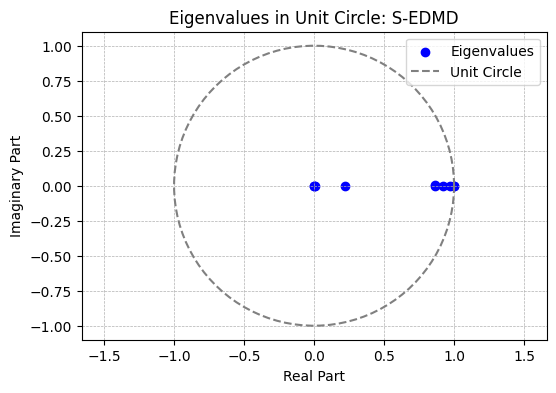

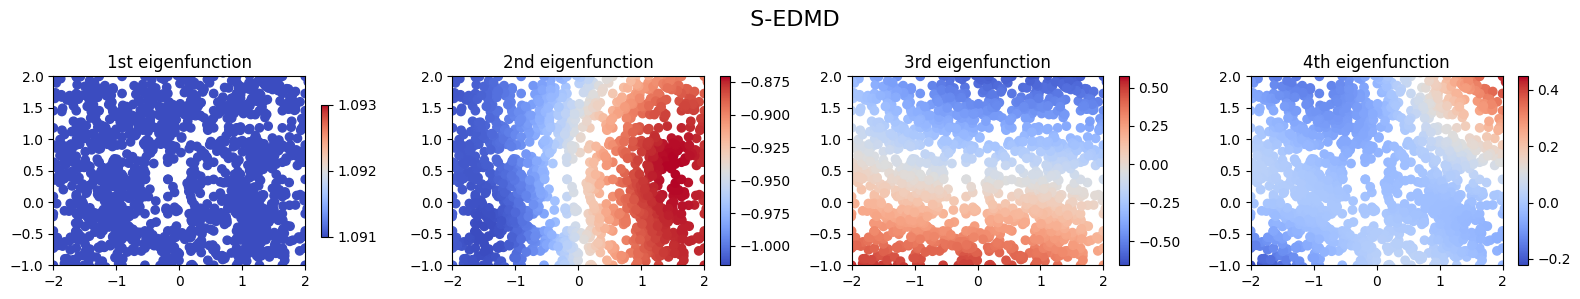

In [10]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5046.65iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4850.21iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 5003.62iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5001.25iteration/s]


Epoch: 1 	Training Loss: 10.684230 val loss: 13.430125
saving, val loss enhanced: 13.430124681249396 1000000000000000.0
Epoch: 2 	Training Loss: 10.668647 val loss: 13.412871
saving, val loss enhanced: 13.412871269389298 13.430124681249396
Epoch: 3 	Training Loss: 10.653311 val loss: 13.395405
saving, val loss enhanced: 13.395405056441867 13.412871269389298
Epoch: 4 	Training Loss: 10.638023 val loss: 13.377867
saving, val loss enhanced: 13.377866665923001 13.395405056441867
Epoch 1 time: 9.32 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5060.43iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5048.33iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5117.88iteration/s]


Epoch: 1 	Training Loss: 10.587946 val loss: 13.308389
saving, val loss enhanced: 13.308389199035568 13.377866665923001
Epoch: 2 	Training Loss: 10.572794 val loss: 13.290923
saving, val loss enhanced: 13.290923241301359 13.308389199035568
Epoch: 3 	Training Loss: 10.557671 val loss: 13.273469
saving, val loss enhanced: 13.273468900700962 13.290923241301359
Epoch: 4 	Training Loss: 10.542571 val loss: 13.256029
saving, val loss enhanced: 13.256029462242173 13.273468900700962
Epoch 2 time: 9.18 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5043.27iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5127.64iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5169.31iteration/s]


Epoch: 1 	Training Loss: 10.492917 val loss: 13.187240
saving, val loss enhanced: 13.187239759595187 13.256029462242173
Epoch: 2 	Training Loss: 10.477944 val loss: 13.169943
saving, val loss enhanced: 13.169943151329262 13.187239759595187
Epoch: 3 	Training Loss: 10.463001 val loss: 13.152673
saving, val loss enhanced: 13.152673369778864 13.169943151329262
Epoch: 4 	Training Loss: 10.448082 val loss: 13.135427
saving, val loss enhanced: 13.135427154099052 13.152673369778864
Epoch 3 time: 9.24 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5108.13iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5080.56iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5029.97iteration/s]


Epoch: 1 	Training Loss: 10.398703 val loss: 13.067145
saving, val loss enhanced: 13.067144904041072 13.135427154099052
Epoch: 2 	Training Loss: 10.383911 val loss: 13.050051
saving, val loss enhanced: 13.050050922326388 13.067144904041072
Epoch: 3 	Training Loss: 10.369149 val loss: 13.032986
saving, val loss enhanced: 13.032985809846325 13.050050922326388
Epoch: 4 	Training Loss: 10.354411 val loss: 13.015945
saving, val loss enhanced: 13.0159449654867 13.032985809846325
Epoch 4 time: 9.12 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5061.17iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4866.50iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4858.67iteration/s]


Epoch: 1 	Training Loss: 10.305241 val loss: 12.948120
saving, val loss enhanced: 12.948119990611003 13.0159449654867
Epoch: 2 	Training Loss: 10.290630 val loss: 12.931232
saving, val loss enhanced: 12.931231758994633 12.948119990611003
Epoch: 3 	Training Loss: 10.276048 val loss: 12.914372
saving, val loss enhanced: 12.91437218942047 12.931231758994633
Epoch: 4 	Training Loss: 10.261490 val loss: 12.897536
saving, val loss enhanced: 12.897536290696975 12.91437218942047
Epoch 5 time: 9.31 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5103.39iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5116.28iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4916.74iteration/s]


Epoch: 1 	Training Loss: 10.212481 val loss: 12.830125
saving, val loss enhanced: 12.830125345278338 12.897536290696975
Epoch: 2 	Training Loss: 10.198048 val loss: 12.813441
saving, val loss enhanced: 12.813440811455965 12.830125345278338
Epoch: 3 	Training Loss: 10.183644 val loss: 12.796784
saving, val loss enhanced: 12.796784387001633 12.813440811455965
Epoch: 4 	Training Loss: 10.169264 val loss: 12.780151
saving, val loss enhanced: 12.78015092460846 12.796784387001633
Epoch 6 time: 9.19 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4709.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4870.10iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4805.21iteration/s]


Epoch: 1 	Training Loss: 10.120374 val loss: 12.713114
saving, val loss enhanced: 12.713113590731709 12.78015092460846
Epoch: 2 	Training Loss: 10.106117 val loss: 12.696630
saving, val loss enhanced: 12.69663006955042 12.713113590731709
Epoch: 3 	Training Loss: 10.091889 val loss: 12.680174
saving, val loss enhanced: 12.68017411039351 12.69663006955042
Epoch: 4 	Training Loss: 10.077684 val loss: 12.663740
saving, val loss enhanced: 12.66374048000555 12.68017411039351
Epoch 7 time: 9.53 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4695.68iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4797.64iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5004.59iteration/s]


Epoch: 1 	Training Loss: 10.028873 val loss: 12.597039
saving, val loss enhanced: 12.597038568420723 12.66374048000555
Epoch: 2 	Training Loss: 10.014791 val loss: 12.580754
saving, val loss enhanced: 12.580753539778856 12.597038568420723
Epoch: 3 	Training Loss: 10.000737 val loss: 12.564496
saving, val loss enhanced: 12.564495576250945 12.580753539778856
Epoch: 4 	Training Loss: 9.986706 val loss: 12.548259
saving, val loss enhanced: 12.548259386755298 12.564495576250945
Epoch 8 time: 9.62 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4760.67iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 5028.40iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4995.45iteration/s]


Epoch: 1 	Training Loss: 9.937937 val loss: 12.481857
saving, val loss enhanced: 12.481857479483258 12.548259386755298
Epoch: 2 	Training Loss: 9.924027 val loss: 12.465769
saving, val loss enhanced: 12.46576866158693 12.481857479483258
Epoch: 3 	Training Loss: 9.910146 val loss: 12.449706
saving, val loss enhanced: 12.449706455536148 12.46576866158693
Epoch: 4 	Training Loss: 9.896287 val loss: 12.433666
saving, val loss enhanced: 12.433665527411701 12.449706455536148
Epoch 9 time: 9.39 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 5000.04iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4795.49iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5095.14iteration/s]


Epoch: 1 	Training Loss: 9.847527 val loss: 12.367532
saving, val loss enhanced: 12.367532080874431 12.433665527411701
Epoch: 2 	Training Loss: 9.833789 val loss: 12.351637
saving, val loss enhanced: 12.351637388823441 12.367532080874431
Epoch: 3 	Training Loss: 9.820078 val loss: 12.335769
saving, val loss enhanced: 12.335768888216768 12.351637388823441
Epoch: 4 	Training Loss: 9.806389 val loss: 12.319921
saving, val loss enhanced: 12.319921211855451 12.335768888216768
Epoch 10 time: 9.32 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5058.08iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5055.77iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5017.98iteration/s]


Epoch: 1 	Training Loss: 9.757612 val loss: 12.254030
saving, val loss enhanced: 12.25402991514009 12.319921211855451
Epoch: 2 	Training Loss: 9.744043 val loss: 12.238327
saving, val loss enhanced: 12.238327414855567 12.25402991514009
Epoch: 3 	Training Loss: 9.730501 val loss: 12.222651
saving, val loss enhanced: 12.222650710425023 12.238327414855567
Epoch: 4 	Training Loss: 9.716981 val loss: 12.206994
saving, val loss enhanced: 12.206994408150903 12.222650710425023
Epoch 11 time: 9.19 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5102.41iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5083.53iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5165.53iteration/s]


Epoch: 1 	Training Loss: 9.668166 val loss: 12.141326
saving, val loss enhanced: 12.141325595619843 12.206994408150903
Epoch: 2 	Training Loss: 9.654765 val loss: 12.125813
saving, val loss enhanced: 12.125813465878084 12.141325595619843
Epoch: 3 	Training Loss: 9.641392 val loss: 12.110327
saving, val loss enhanced: 12.110326755534311 12.125813465878084
Epoch: 4 	Training Loss: 9.628039 val loss: 12.094860
saving, val loss enhanced: 12.094860049674676 12.110326755534311
Epoch 12 time: 9.08 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4866.47iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4968.93iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5138.31iteration/s]


Epoch: 1 	Training Loss: 9.579176 val loss: 12.029402
saving, val loss enhanced: 12.029401982762472 12.094860049674676
Epoch: 2 	Training Loss: 9.565942 val loss: 12.014078
saving, val loss enhanced: 12.014078482943832 12.029401982762472
Epoch: 3 	Training Loss: 9.552734 val loss: 11.998780
saving, val loss enhanced: 11.998780040942613 12.014078482943832
Epoch: 4 	Training Loss: 9.539548 val loss: 11.983501
saving, val loss enhanced: 11.983501225188531 11.998780040942613
Epoch 13 time: 9.24 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4855.40iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5099.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5140.58iteration/s]


Epoch: 1 	Training Loss: 9.490635 val loss: 11.918251
saving, val loss enhanced: 11.918251048019894 11.983501225188531
Epoch: 2 	Training Loss: 9.477566 val loss: 11.903114
saving, val loss enhanced: 11.903114488859982 11.918251048019894
Epoch: 3 	Training Loss: 9.464524 val loss: 11.888003
saving, val loss enhanced: 11.888002637319637 11.903114488859982
Epoch: 4 	Training Loss: 9.451502 val loss: 11.872910
saving, val loss enhanced: 11.872910049522236 11.888002637319637
Epoch 14 time: 9.30 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5061.30iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5132.37iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5083.22iteration/s]


Epoch: 1 	Training Loss: 9.402548 val loss: 11.807874
saving, val loss enhanced: 11.807874238778586 11.872910049522236
Epoch: 2 	Training Loss: 9.389643 val loss: 11.792923
saving, val loss enhanced: 11.792922954929107 11.807874238778586
Epoch: 3 	Training Loss: 9.376764 val loss: 11.777996
saving, val loss enhanced: 11.777996036817559 11.792922954929107
Epoch: 4 	Training Loss: 9.363906 val loss: 11.763088
saving, val loss enhanced: 11.763088032730783 11.777996036817559
Epoch 15 time: 9.25 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4928.54iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4984.64iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 5022.54iteration/s]


Epoch: 1 	Training Loss: 9.314930 val loss: 11.698282
saving, val loss enhanced: 11.698282215607714 11.763088032730783
Epoch: 2 	Training Loss: 9.302188 val loss: 11.683515
saving, val loss enhanced: 11.683514540046195 11.698282215607714
Epoch: 3 	Training Loss: 9.289472 val loss: 11.668771
saving, val loss enhanced: 11.66877089389005 11.683514540046195
Epoch: 4 	Training Loss: 9.276776 val loss: 11.654046
saving, val loss enhanced: 11.654045822362255 11.66877089389005
Epoch 16 time: 9.30 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:01<00:00, 5075.59iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[2.27874470e+01+0.j         4.84515896e+00+0.j
 1.69717597e+00-0.34431548j 1.69717597e+00+0.34431548j
 1.10846295e+00+0.j         1.00000000e+00+0.j
 9.10894289e-01-0.08841162j 9.10894289e-01+0.08841162j
 1.30228447e-02+0.j         7.85191326e-03+0.j        ]


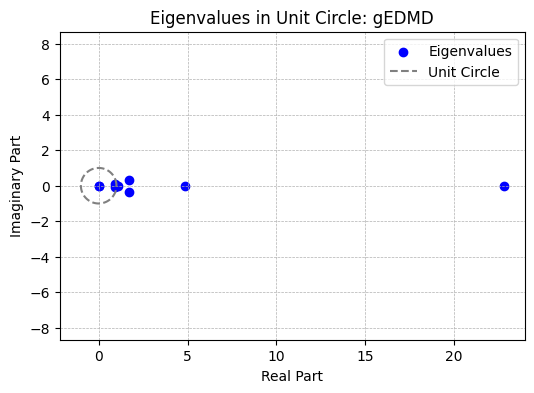

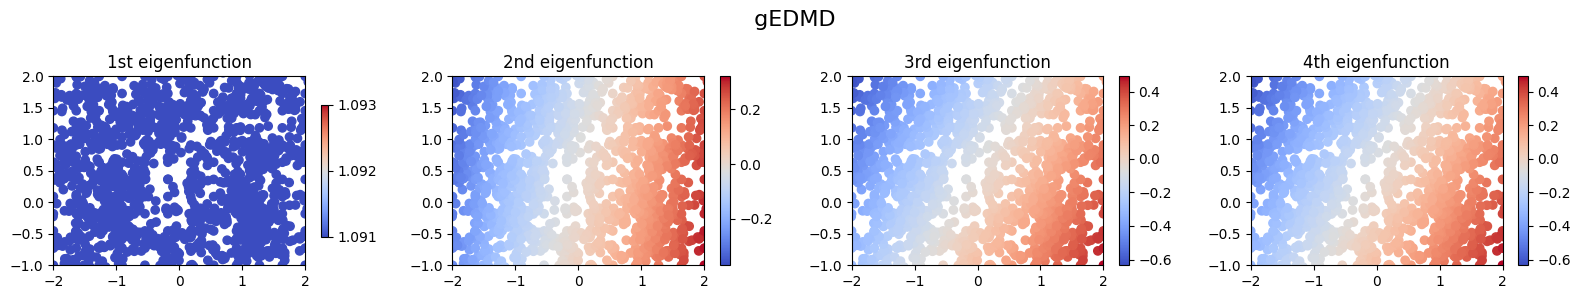

In [12]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
